<a href="https://colab.research.google.com/github/YeonwooSung/ai_book/blob/master/LLMs/src/Automatic_detection_of_hallucination_with_SelfCheckGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic detection of hallucination with SelfCheckGPT

This notebook helps understand how hallucination metrics, such as SelfCheckGPT NLI score, can be used to automatically detect hallucinations.

We will explore
- Heuristics on why LLMs hallucinate and how it could be automatically detected with metrics that measure sentences' inconsistency
- How to actually verify that hypothesis with the SelfCheckGPT NLI score on a real dataset derived from the WikiBio, to benchmark how accurate this metric is to detect hallucination automatically and reliably

Our initial results show that this hallucination score has a rather calibrated recall, and high precision. This means that the higher the score, the more likely the model will be able to flag hallucinations (calibrated recall), and any flagged hallucination is almost certainly one (high precision, aka low false positive).

As we work at [Mithril Security](https://www.mithrilsecurity.io/) on Confidential and Trustworthy Conversational AI, being able to know when an LLM is not to be trusted is paramount.
You can try BlindChat, our open-source and Confidential Conversational AI (aka any data sent to our AI remains private and not even our admins can see your prompts) at [chat.mithrilsecurity.io](https://chat.mithrilsecurity.io/).

While the hallucination detection feature is not yet available in BlindChat, if you are interested in it, you can register [here](https://www.mithrilsecurity.io/registration-for-automated-hallucination-detection-in-blindchat) to show your interest in it so we know how to prioritize it and notify you when it is available.

# Context

## Heuristic on hallucination origins

LLMS have shown tremendous potential recently, but their tendency to hallucinate wrong facts when prompted on specific tasks has made them unreliable in many real world settings.

For instance, if one were to deploy an LLM to help triage patients and answer simple medical questions, having an LLM hallucinate answers that are not medically grounded could have terrible consequences.

Hallucinations often arise from the fact that LLMs are asked to answer prompts whose task / input / output was not present in the training set, and therefore will produce an answer not based on any ground truth.

This makes sense when one knows that those models are taught to produce the most probable next token according to the statistics of their training set.

Work from [McCoy, R. T., Yao, S., Friedman, D., Hardy, M., & Griffiths, T. L. (2023). Embers of Autoregression: Understanding Large Language Models Through the Problem They are Trained to Solve.](https://arxiv.org/abs/2309.13638)
shows that unseen tasks / outputs / inputs in the training set are the reason why LLMs hallucinate.

![](https://github.com/dhuynh95/hallucination_article/blob/main/embers_graph.png?raw=true)

For instance, they show that on the simple task of doing a Cesar Cipher of 13 (aka shifting every letter by 13 to hide information), GPT4 is rather accurate. However, when asked to do it with a shift of 2, its accuracy decreases from 0.5 to almost 0. This is most likely due to the fact that the Internet is full of examples of a shift of 13 (as doing it twice sends back to the original message), while examples of Cesar of 2 are much less common.

We can see the same patterns when the prompt and answer are not seen in the training set.

This means that unlikely outputs, aka ones where the next token has a low score, will most likely be unfactual and several samples from the same prompt will generate inconsistent results.

## Automatic hallucination detection

This insight is leveraged by SelfCheckGPT ([Manakul, P., Liusie, A., & Gales, M. J. F. (2023). SelfCheckGPT: Zero-Resource Black-Box Hallucination Detection for Generative Large Language Models.](https://arxiv.org/abs/2303.08896)), as several samples of the same prompt are drawn, and used to detect inconsistencies among them. The higher the inconsistencies, the more likely the LLM is hallucinating.

The way SelfCheckGPT NLI provides a hallucination score for a given prompt to a given LLM (e.g. GPT4 or any open-source LLM):
- Greedily sample the answer $r$ to the prompt
- Sample $N$ more answers ${S^n}, n \in [[1,N]]$ from the LLM
- For each sentence in $r_i$ of $r$, for each sampled answer $S_n$, compute the likelihood there is a contradiction between $r_i$ and $S^n$ using a model for Natural Language Inference (NLI) like [DeBERTa-v3-large](https://huggingface.co/microsoft/deberta-v3-large). The more likely there is contradiction, the more the score will be close to 1, and vice versa if there is entailment.
$$P(\text{contradict} | r_i, S^n) = \frac{\exp(z_c)}{\exp(z_e) + \exp(z_c)}$$
- Compute the hallucination score of the sentence $r_i$ by averaging it over the $N$ samples:
$$S_{\text{NLI}}(i) = \frac{1}{N} \sum_{n=1}^{N} P(\text{contradict} | r_i, S^n)$$

Note that the SelfCheckGPT NLI score has several advantages:
- It works in a blackbox setting, aka there is no need to have access to the weights or the log probabilities, which means it works with both closed-source models being APIs or fully transparent open-source models
- It works for free text generation, aka it covers almost any task, be it summarization, question answering in free form, or classification

The reasoning why such an inconsistency score can be used to automatically detect hallucinations is the following:
- The less seen in the training set a specific task is, the more the LLM will be hallucinating (cf. the Embers of autoregression paper mentioned earlier)
- The less seen a specific task is seen in the training set, the less confident the  LLM will be in the next token to choose (aka higher entropy and the most likely token will have a low score, let's say 0.3, versus a very certain output of 0.9)
- The higher the entropy, the more diverse and inconsistent different samples from the same prompt will be
- The more inconsistent the samples, the higher a metric which looks at inconsistency between sentences, like SelfCheckGPT NLI score, is

# Exploration of hallucination score on WikiBio

Now that we have understood how an inconsistency score like SelfCheckGPT NLI can be used to detect hallucinations, let's see its performance in practice.

To do so, we will use the Wiki Bio hallucination dataset curated by the authors of SelfCheckGPT. It can be found on Hugging Face [here](https://huggingface.co/datasets/potsawee/wiki_bio_gpt3_hallucination).

To test whether or not a model is hallucinating, they constructed a dataset where they asked GPT-3 to generate description of topics with the prompt format **"This is a Wikipedia passage about {concept}:"**, recorded the output, and then manually labelled each sentence of the generated text by humans to have a gold standard about factuality. The labels were "Accurate" (0), "Minor Inaccurate" (0.5) and "Major Inaccurate" (1).  

Then they generated $N=20$ additional samples, that will be used to detect hallucination through inconsistency scoring.

## Setup

First we install the needed libraries.

In [1]:
!pip install transformers datasets
!pip install sentencepiece
!pip install selfcheckgpt
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.4 MB/s eta 0:00:00
  Created wheel for selfcheckgpt: filename=selfcheckgpt-0.1.4-py3-none-any.whl size=12240 sha256=b84177b1233dcd1d27681e31c4adedd25d5ec594ef3b08e0a47f73c8f4477c45
  Stored in directory: /root/.cache/pip/wheels/dc/a6/76/107247d4924cb23f6e1b1987413b2a191979767e1e2c1d5751
Successfully built selfcheckgpt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 51.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1

Now we will download the Wiki bio dataset.

In [2]:
from datasets import load_dataset

dataset = load_dataset("potsawee/wiki_bio_gpt3_hallucination")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating evaluation split:   0%|          | 0/238 [00:00<?, ? examples/s]

Let us convert it to a DataFrame.

In [3]:
import pandas as pd

df = pd.DataFrame([example for example in dataset["evaluation"]])
df["sent_scores_nli"] = None

In [4]:
df.loc[[0]]

,gpt3_text,wiki_bio_text,gpt3_sentences,annotation,wiki_bio_test_idx,gpt3_text_samples,sent_scores_nli
0,John Russell Reynolds (1820–1876) was an Engli...,"Sir John Russell Reynolds, 1st Baronet (22 May...",[John Russell Reynolds (1820–1876) was an Engl...,"[major_inaccurate, major_inaccurate, major_ina...",62464,[John Russell Reynolds (1 November 1829 – 11 ...,None


- gpt3_text is the output of the prompt "This is a Wikipedia passage about {concept}:"
- wiki_bio_text is the ground truth
- gpt3_sentences is gpt3_text split into sentences
- annotation is the label
- gpt3_text_samples are the $N$ samples generated to detect inconsistency.

We can have a look here at samples:

In [5]:
example = dataset["evaluation"][0]

sentences = example["gpt3_sentences"]
samples = example["gpt3_text_samples"]
annotation = example["annotation"]

sentences, samples[0], annotation

(['John Russell Reynolds (1820–1876) was an English lawyer, judge, and author.',
  'He was born in London, the son of a barrister, and was educated at Eton College and Trinity College, Cambridge.',
  "He was called to the bar in 1845, and became a Queen's Counsel in 1859.",
  'He was appointed a judge of the Court of Common Pleas in 1867, and was knighted in 1871.',
  'Reynolds was a prolific author, writing on a wide range of topics.',
  'He wrote several books on legal topics, including The Law of Libel and Slander (1863), The Law of Copyright (1865), and The Law of Patents for Inventions (1868).',
  'He also wrote on a variety of other topics, including history, biography, and literature.',
  'He was a frequent contributor to the Saturday Review, and wrote several books on Shakespeare, including The Mystery of William Shakespeare (1848) and The Authorship of Shakespeare (1875).',
  'He also wrote a biography of the poet John Keats (1848).'],
 'John Russell Reynolds (1 November 1829 

## Computing the NLI Scores

Recalculate the NLI scores of the original wiki bio dataset.

In [6]:
from tqdm import tqdm
from selfcheckgpt.modeling_selfcheck import SelfCheckNLI
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
selfcheck_nli = SelfCheckNLI(device=device) # set device to 'cuda' if GPU is available

for index, example in tqdm(df.iterrows()):
  sentences = example["gpt3_sentences"]
  samples = example["gpt3_text_samples"]
  sent_scores_nli = selfcheck_nli.predict(
    sentences = sentences,                          # list of sentences
    sampled_passages = samples, # list of sampled passages
  )
  df.loc[index, "sent_scores_nli"] = str(list(sent_scores_nli)) # Store the scores in the sent_scores_nli column
  df.to_csv("./wiki_bio_gpt3_hallucination.csv", index=False)

tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

SelfCheck-NLI initialized to device cuda


238it [49:53, 12.58s/it]


## Computing the recall and precision scores for calibrated hallucination plots

As computing the NLI scores takes time, we have already done it and made the scores available for you to play with it directly:

In [7]:
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15MYaz18UXv3GCaP0ObBbIJ_0u18cBcXH' -O wiki_bio_gpt3_hallucination.csv

--2023-12-02 07:07:27--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-12-02 07:07:28--  https://docs.google.com/uc?export=download&id=15MYaz18UXv3GCaP0ObBbIJ_0u18cBcXH
Resolving docs.google.com (docs.google.com)... 142.250.103.139, 142.250.103.138, 142.250.103.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/649atnliq1o28ufu0lp71ns955urcb5v/1701500775000/08030308599197976876/*/15MYaz18UXv3GCaP0ObBbIJ_0u18cBcXH?e=download&uuid=31531d47-4895-44de-a799-f6c583592ecb [following]
--2023-12-02 07:07:29--  https://doc-0c-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/649atnliq1o28ufu0lp71ns955urcb5v/1701500775000/08030308599197976876/*/15MYaz18UXv3GCaP0ObBbIJ_0u18cBcXH?e=download&uuid=31531d

In [8]:
import pandas as pd

df = pd.read_csv("./wiki_bio_gpt3_hallucination.csv")
df

,gpt3_text,wiki_bio_text,gpt3_sentences,annotation,wiki_bio_test_idx,gpt3_text_samples,sent_scores_nli
0,John Russell Reynolds (1820–1876) was an Engli...,"Sir John Russell Reynolds, 1st Baronet (22 May...",['John Russell Reynolds (1820–1876) was an Eng...,"['major_inaccurate', 'major_inaccurate', 'majo...",62464,['John Russell Reynolds (1 November 1829 – 11...,"[0.8696355807129293, 0.9287475407123565, 0.931..."
1,"Matthew Aylmer, 1st Baron Aylmer (1708–1794) w...","Admiral of the Fleet Matthew Aylmer, 1st Baron...","['Matthew Aylmer, 1st Baron Aylmer (1708–1794)...","['minor_inaccurate', 'minor_inaccurate', 'mino...",49661,"['""Matthew Aylmer, 1st Baron Aylmer (c. 1650–1...","[0.9112446781247854, 0.9620911836624145, 0.997..."
2,Rick Mahler (born Richard Alan Mahler on April...,"Richard Keith Mahler (August 5, 1953 in Austin...",['Rick Mahler (born Richard Alan Mahler on Apr...,"['minor_inaccurate', 'minor_inaccurate', 'accu...",20483,"['Rick Mahler (January 8, 1956 – May 25, 2005)...","[0.9891034990549088, 0.4388777802581899, 0.955..."
3,James Blair (1732–1782) was an American lawyer...,"James Blair (September 26, 1786 - April 1, 183...",['James Blair (1732–1782) was an American lawy...,"['minor_inaccurate', 'major_inaccurate', 'majo...",71174,"['James Blair (April 2, 1755 – March 8, 1842) ...","[0.9353850647807121, 0.8861920005059801, 0.993..."
4,"Tim Finchem (born August 24, 1947) is an Ameri...","Timothy W. Finchem (born April 19, 1947) is th...","['Tim Finchem (born August 24, 1947) is an Ame...","['minor_inaccurate', 'accurate', 'major_inaccu...",39945,"['""Tim Finchem (born May 27, 1953) is an Ameri...","[0.9961978942155838, 0.2596603611658793, 0.992..."
...,...,...,...,...,...,...,...
233,Gündüz Kılıç (born 28 April 1988) is a Turkish...,Baba Gündüz Kılıç (1918-1980) was a Turkish fo...,['Gündüz Kılıç (born 28 April 1988) is a Turki...,"['minor_inaccurate', 'major_inaccurate', 'majo...",25585,"[""Gündüz Kılıç (1518 – 1567) was an Ottoman na...","[0.9997160047292709, 0.998373419046402, 0.9956..."
234,Michael Replogle (born 1951) is an American en...,Michael Replogle is an internationally recogni...,['Michael Replogle (born 1951) is an American ...,"['accurate', 'accurate', 'accurate', 'accurate...",10740,"[""Michael Replogle (born 1946) is an American ...","[0.35181010272353885, 0.37309717537864345, 0.0..."
235,"Billy Burke (born October 28, 1894 – died Apri...",William John Burke (Polonized as Burkeauskas; ...,"['Billy Burke (born October 28, 1894 – died Ap...","['minor_inaccurate', 'major_inaccurate', 'majo...",41463,['Billy Burke (21 August 1882 – 22 December 19...,"[0.9992900729179383, 0.9886163860559464, 0.996..."
236,"Ted Childs (born October 15, 1956) is an Ameri...",Ted Childs commenced training as a programme d...,"['Ted Childs (born October 15, 1956) is an Ame...","['major_inaccurate', 'major_inaccurate', 'majo...",57341,"['""Ted Childs was an American actor and busine...","[0.9853663831949234, 0.7629887842107564, 0.920..."


Now that we have the hallucination score with NLI for each sentence, we will create a DataFrame to facilitate the computing of precision and recalls for hallucination.

In [9]:
import ast

output_df = []

for _, row in df.iterrows():
  scores = row["sent_scores_nli"]
  scores = ast.literal_eval(scores) # We recreate the list of scores per sentence
  sentences = ast.literal_eval(row["gpt3_sentences"])
  annotations = ast.literal_eval(row["annotation"])
  for i, annotation in enumerate(annotations):
    idx = len(output_df)

    output_df.append({
        "index": idx,
        "sentence": sentences[i],
        "wiki_bio_text": row["wiki_bio_text"],
        "annotation": annotation,
        "probability": scores[i]
    })

output_df = pd.DataFrame(output_df)

We will use the following convention:
- Label: 1 means a human annotated the sentence to be a hallucination and is the gold standard, 0 means truth.
- Probability: Probability of hallucination, which is just the previous NLI score.
- Prediction: Predicted label, 1 if the score is above 0.35, else 0.

In [10]:
output_df["label"] = output_df.annotation.apply(lambda x: 0 if x == "accurate" else 1) # We add the ground truth label

In [11]:
threshold = 0.35
output_df["prediction"] = output_df["probability"].apply(lambda x: 1 if x > threshold else 0) # We add the predicted label

In [12]:
output_df

,index,sentence,wiki_bio_text,annotation,probability,label,prediction
0,0,John Russell Reynolds (1820–1876) was an Engli...,"Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.869636,1,1
1,1,"He was born in London, the son of a barrister,...","Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.928748,1,1
2,2,"He was called to the bar in 1845, and became a...","Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.931370,1,1
3,3,He was appointed a judge of the Court of Commo...,"Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.982257,1,1
4,4,"Reynolds was a prolific author, writing on a w...","Sir John Russell Reynolds, 1st Baronet (22 May...",major_inaccurate,0.221962,1,0
...,...,...,...,...,...,...,...
1903,1903,He was appointed Dean of Clonfert in 1760 and ...,Edward Synge (1659–1741) was an Anglican clerg...,major_inaccurate,0.999400,1,1
1904,1904,"In 1781 he was appointed Archbishop of Tuam, a...",Edward Synge (1659–1741) was an Anglican clerg...,minor_inaccurate,0.941169,1,1
1905,1905,Synge was a noted scholar and a friend of the ...,Edward Synge (1659–1741) was an Anglican clerg...,minor_inaccurate,0.755755,1,1
1906,1906,He was a strong supporter of the Church of Ire...,Edward Synge (1659–1741) was an Anglican clerg...,minor_inaccurate,0.677196,1,1


Let's have a look at the distribution of hallucination score:

<Axes: >

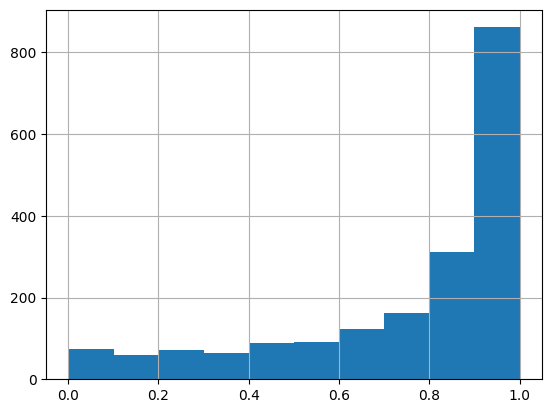

In [13]:
output_df.probability.hist()

Let's look at sentences which have a high hallucination score:

In [14]:
sorted_df = output_df.sort_values(by='probability', ascending=False)
sorted_df

,index,sentence,wiki_bio_text,annotation,probability,label,prediction
1111,1111,Paul Taylor (born Paul Taylor Winger on April ...,"Paul Taylor (born June 4, 1960, San Francisco,...",minor_inaccurate,0.999736,1,1
1867,1867,Gündüz Kılıç (born 28 April 1988) is a Turkish...,Baba Gündüz Kılıç (1918-1980) was a Turkish fo...,minor_inaccurate,0.999716,1,1
1205,1205,Joe Walsh (born 28 April 1988) is an English p...,"For other persons named Joseph/Joe Walsh, see ...",minor_inaccurate,0.999713,1,1
1435,1435,"Stan Heal (born October 28, 1932) is an Americ...","Stan ""Pops"" Heal (30 July 1920 - 15 December 2...",major_inaccurate,0.999712,1,1
1114,1114,"Taylor was born in Cleveland, Ohio, and grew u...","Paul Taylor (born June 4, 1960, San Francisco,...",major_inaccurate,0.999675,1,1
...,...,...,...,...,...,...,...
1215,1215,"He was a major benefactor of the city, donatin...",Sir Josiah Mason (23 February 1795 - 16 June 1...,accurate,0.008564,0,0
440,440,Tommy Nutter (1943–1992) was a British tailor ...,Tommy Nutter (17 April 1943 – 17 August 1992) ...,accurate,0.004858,0,0
905,905,"Lindsay Crouse (born May 12, 1948) is an Ameri...","Lindsay Ann Crouse (born May 12, 1948) is an A...",accurate,0.003348,0,0
1211,1211,Josiah Mason (1795–1881) was an English indust...,Sir Josiah Mason (23 February 1795 - 16 June 1...,accurate,0.001838,0,0


We can see below that a sentence with a very high hallucination score (0.99) is indeed looking like a hallucination, as the sentence misses two facts:
- Stan Heal is born on the 30th July 1920, which is quite far from the LLM generation of October 28th 1932!
- Stan was a football player and not a basketball player.

In [15]:
sorted_df

,index,sentence,wiki_bio_text,annotation,probability,label,prediction
1111,1111,Paul Taylor (born Paul Taylor Winger on April ...,"Paul Taylor (born June 4, 1960, San Francisco,...",minor_inaccurate,0.999736,1,1
1867,1867,Gündüz Kılıç (born 28 April 1988) is a Turkish...,Baba Gündüz Kılıç (1918-1980) was a Turkish fo...,minor_inaccurate,0.999716,1,1
1205,1205,Joe Walsh (born 28 April 1988) is an English p...,"For other persons named Joseph/Joe Walsh, see ...",minor_inaccurate,0.999713,1,1
1435,1435,"Stan Heal (born October 28, 1932) is an Americ...","Stan ""Pops"" Heal (30 July 1920 - 15 December 2...",major_inaccurate,0.999712,1,1
1114,1114,"Taylor was born in Cleveland, Ohio, and grew u...","Paul Taylor (born June 4, 1960, San Francisco,...",major_inaccurate,0.999675,1,1
...,...,...,...,...,...,...,...
1215,1215,"He was a major benefactor of the city, donatin...",Sir Josiah Mason (23 February 1795 - 16 June 1...,accurate,0.008564,0,0
440,440,Tommy Nutter (1943–1992) was a British tailor ...,Tommy Nutter (17 April 1943 – 17 August 1992) ...,accurate,0.004858,0,0
905,905,"Lindsay Crouse (born May 12, 1948) is an Ameri...","Lindsay Ann Crouse (born May 12, 1948) is an A...",accurate,0.003348,0,0
1211,1211,Josiah Mason (1795–1881) was an English indust...,Sir Josiah Mason (23 February 1795 - 16 June 1...,accurate,0.001838,0,0


In [16]:
example = sorted_df.iloc[3]
example["sentence"], example["wiki_bio_text"], example["probability"]

('Stan Heal (born October 28, 1932) is an American former professional basketball player.',
 'Stan "Pops" Heal (30 July 1920 - 15 December 2010) was an Australian rules footballer who played for Melbourne in the Victorian Football League (VFL) as well as West Perth in the West Australian National Football League (WANFL) during the 1940s and early 1950s. Heal played his best football as a wingman but was also used on occasions as a rover. The Western Australian spent just one season at Melbourne, who had acquired his services while he was temporarily stationed in Victoria. Despite playing just eight games, he was a member of Melbourne\'s 1941 premiership team. The following week, he played in another premiership, back home in Western Australia with West Perth. He was also a regular interstate representative for Western Australia, winning a Simpson Medal for his performance in a game against South Australia in 1949 and captaining his state at the 1950 Brisbane Carnival. As coach of West 

## Interpretation of results

Let's now have a look at the calibrated scores of recall and precision. Calibration is key in building trust in a model. Ideally, when a model provides a 0.8 probability score that a given sample is a hallucination, one would like it to be the case that this prediction would hold true 80% of the time.

As hallucinations labelling could happen in imbalanced settings, for instance, if we ask the LLM to perform easy vs hard tasks, precision and recall are more relevant.

That is why we will look at precision and recall for different probability scores.

Hallucination recall conveys the number of hallucinations that are detected by our model for a given data set. If the recall is of 0.8, it means that we have properly flagged 80% of the hallucinations.

Hallucination precision conveys how often predicted hallucinations actually are hallucinations, and not false positives. An accuracy of 0.8 would mean that 80% of the time when we say a sentence is a hallucination, it is indeed one.

So first let's plot the precision scores grouped per bins of similar hallucination score.

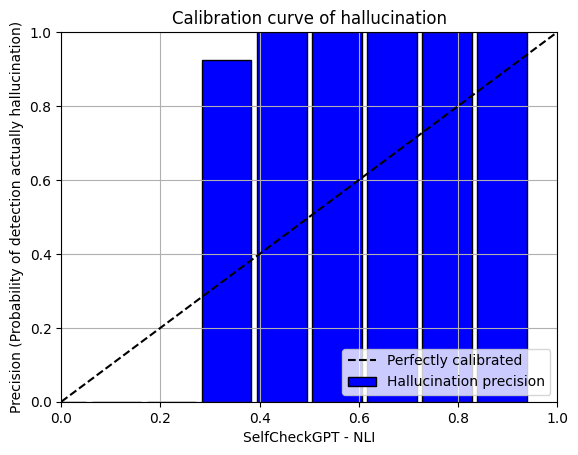

In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

x = []
precisions = []

n_bins = 10
thresholds = np.linspace(0,1,n_bins)
for i in range(len(thresholds)-1):
  min = thresholds[i]
  max = thresholds[i+1]
  bin = output_df.loc[(output_df.probability >= min) & (output_df.probability < max)]
  tp = ((bin.prediction == 1) & (bin.label == 1)).sum()
  fn = ((bin.prediction == 0) & (bin.label == 1)).sum()
  precision = precision_score(bin.prediction.values, bin.label.values)
  x.append(min)
  precisions.append(precision)

plt.bar(x, precisions, width=0.1, color='blue', edgecolor='black', capsize=5, align='center', label='Hallucination precision')
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('SelfCheckGPT - NLI')
plt.ylabel('Precision (Probability of detection actually hallucination)')
plt.title('Calibration curve of hallucination')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


Now let's do the same for recall:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


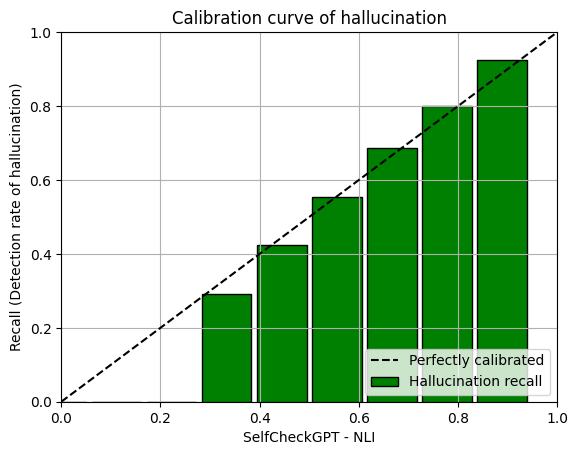

In [18]:
x = []
recalls = []

n_bins = 10
thresholds = np.linspace(0,1,n_bins)
for i in range(len(thresholds)-1):
  min = thresholds[i]
  max = thresholds[i+1]
  bin = output_df.loc[(output_df.probability >= min) & (output_df.probability < max)]
  tp = ((bin.prediction == 1) & (bin.label == 1)).sum()
  fn = ((bin.prediction == 0) & (bin.label == 1)).sum()
  # precision = tp / (tp + fn)
  recall = recall_score(bin.prediction.values, bin.label.values)
  # x.append(f"\[{min}-{max}\]")
  x.append(min)
  recalls.append(recall)

plt.bar(x, recalls, width=0.1, color='green', edgecolor='black', capsize=5, align='center', label='Hallucination recall')
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('SelfCheckGPT - NLI')
plt.ylabel('Recall (Detection rate of hallucination)')
plt.title('Calibration curve of hallucination')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


We can plot the two side by side:

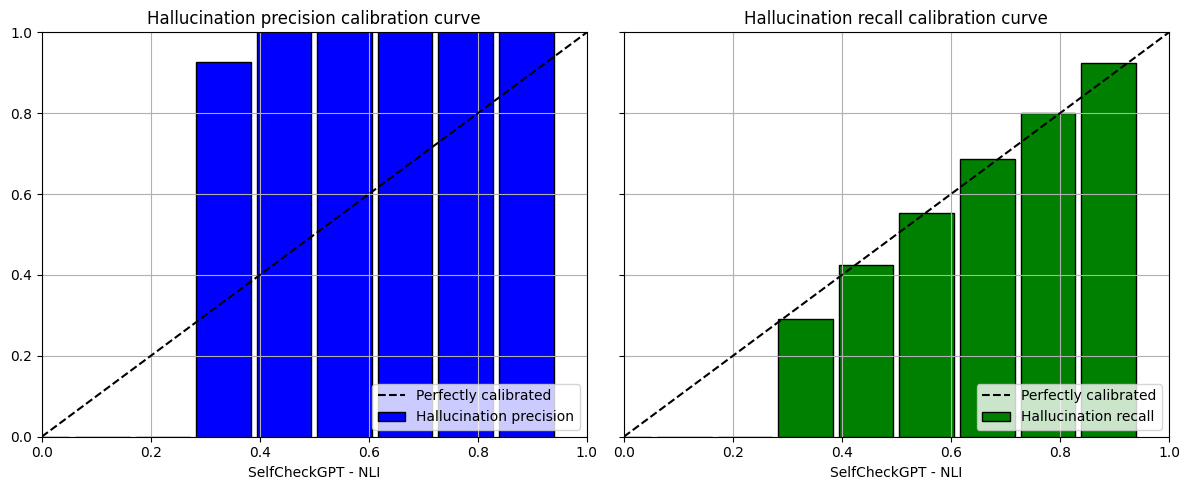

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot the first histogram
axs[0].bar(x, precisions, width=0.1, color='blue', edgecolor='black', capsize=5, align='center', label='Hallucination precision')
axs[0].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
axs[0].set_xlim([0, 1])
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('SelfCheckGPT - NLI')
axs[0].set_title('Hallucination precision calibration curve')
axs[0].legend(loc='lower right')
axs[0].grid(True)

# Plot the second histogram
axs[1].bar(x, recalls, width=0.1, color='green', edgecolor='black', capsize=5, align='center', label='Hallucination recall')
axs[1].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
axs[1].set_xlim([0, 1])
axs[1].set_ylim([0, 1])
axs[1].set_xlabel('SelfCheckGPT - NLI')
axs[1].set_title('Hallucination recall calibration curve')
axs[1].legend(loc='lower right')
axs[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()

So what can be an interpretation of these plots?

We see that our model is extremely precise in detecting hallucinations once the score is above 0.5. It reaches perfect precision, which means that whenever it makes the prediction that a sentence is a hallucination, it is almost certain it is actually the case!

But being precise is not enough, if a model is conservative and only flags a few sentences as hallucinations, then this model would not be very useful.

That is why we need to have a look at recall too.

Interestingly, the recall score seems to be calibrated with the probability of hallucination: the higher the probability the higher the recall!

This means that for instance, for an NLI score of 0.8, this model will flag 80% of the hallucinations as the recall is close to 80%, and all examples flagged are actually hallucinations as the precision is 1.0.

This is great! It means that we can have a trustworthy metric for hallucination, as it is able to both:
- Provide a calibrated ability to flag hallucinations, aka the higher the hallucination score, the higher the likelihood to find hallucinations (calibrated recall)
- Be extremely precise in its prediction, aka not falsely labelling truthful sentences as hallucinations (perfect precision)

**Both of those properties mean that we can now reliably and automatically detect hallucinations. This means we could either verify the trustworthiness of an answer in a chat, and when a hallucination is detected, notify the user that extra checks must be performed.**

## Varying the number of samples required

Before concluding, one might think that this is great but how about the cost of such metric?

In the initial SelfCheckGPT paper, they sampled $N=20$ more answers, on top of the original prediction, to predict the hallucination score.

This is therefore quite expensive and impractical as it would drastically increase cost and time.

Therefore, one could think, are that many samples needed?

To study that, we varied the number of samples used to compute the NLI score, and plotted the same graphs with $N=3,10,20$.

In [20]:
!wget wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FFCXP4zBoyr6FwYn_Ken8Ak-6IHwgENv' -O wiki_bio_gpt3_hallucination_all_samples.csv

--2023-12-02 07:07:31--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2023-12-02 07:07:31--  https://docs.google.com/uc?export=download&id=1FFCXP4zBoyr6FwYn_Ken8Ak-6IHwgENv
Resolving docs.google.com (docs.google.com)... 142.250.103.139, 142.250.103.138, 142.250.103.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cjpue7bj3vuo4flmihsiem0ku1lqtfd1/1701500850000/08030308599197976876/*/1FFCXP4zBoyr6FwYn_Ken8Ak-6IHwgENv?e=download&uuid=92fa8f40-2c49-44a5-9ac3-821a30f3475c [following]
--2023-12-02 07:07:33--  https://doc-14-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cjpue7bj3vuo4flmihsiem0ku1lqtfd1/1701500850000/08030308599197976876/*/1FFCXP4zBoyr6FwYn_Ken8Ak-6IHwgENv?e=download&uuid=92fa8f

In [21]:
import pandas as pd

df = pd.read_csv("./wiki_bio_gpt3_hallucination_all_samples.csv")

In [22]:
import ast
import numpy as np

total_samples = 20
n_sample = 3

def get_scores_from_df(df, n_sample=20, total_samples=20, threshold=0.35):

    output_df = []

    for _, example in df.iterrows():
        scores = np.frombuffer(ast.literal_eval(example["sent_scores_nli"]))
        sentences = ast.literal_eval(example["gpt3_sentences"])
        n_sentences = len(sentences)
        scores = scores.reshape(n_sentences, total_samples)
        scores = scores[:,:n_sample]
        scores = scores.mean(axis=-1)

        annotations = ast.literal_eval(example["annotation"])
        for i, annotation in enumerate(annotations):
            idx = len(output_df)

            output_df.append({
                "index": idx,
                "annotation": annotation,
                "probability": scores[i]
            })

    output_df = pd.DataFrame(output_df)
    output_df["label"] = output_df.annotation.apply(lambda x: 0 if x == "accurate" else 1) # We add the ground truth label
    output_df["prediction"] = output_df["probability"].apply(lambda x: 1 if x > threshold else 0) # We add the predicted label
    return output_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due

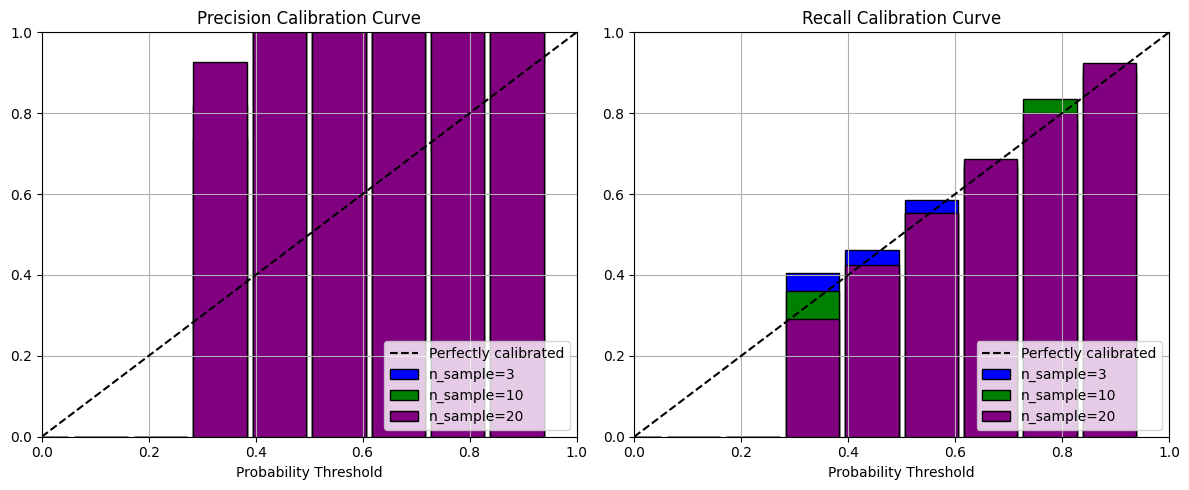

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score

n_samples = [3, 10, 20]
total_samples = 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Single row, two columns

n_bins = 10
thresholds = np.linspace(0, 1, n_bins)

colors = ['blue', 'green', 'purple', 'orange']  # Different color for each n_sample

for j, n_sample in enumerate(n_samples):
    output_df = get_scores_from_df(df, n_sample=n_sample, total_samples=total_samples)
    precisions = []
    recalls = []
    x = []

    for i in range(len(thresholds) - 1):
        min_threshold = thresholds[i]
        max_threshold = thresholds[i + 1]
        bin_df = output_df.loc[(output_df.probability >= min_threshold) & (output_df.probability < max_threshold)]
        precision = precision_score(bin_df.prediction.values, bin_df.label.values)
        recall = recall_score(bin_df.prediction.values, bin_df.label.values)
        x.append(min_threshold)
        precisions.append(precision)
        recalls.append(recall)

    # Plot precision and recall for this n_sample
    ax1.bar(x, precisions, width=0.1, color=colors[j], edgecolor='black', label=f'n_sample={n_sample}')
    ax2.bar(x, recalls, width=0.1, color=colors[j], edgecolor='black', label=f'n_sample={n_sample}')

# Set properties for precision plot
ax1.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xlabel('Probability Threshold')
ax1.set_title('Precision Calibration Curve')
ax1.legend(loc='lower right')
ax1.grid(True)

# Set properties for recall plot
ax2.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xlabel('Probability Threshold')
ax2.set_title('Recall Calibration Curve')
ax2.legend(loc='lower right')
ax2.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


While we can observe slight differences, the overall behavior is the same, even for $N=3$.

While still being a high number and multiplying the cost by 4, this initial work provides a first lead towards a practical, generic, and automatic way to detect hallucinations to build Trustworthy AI systems.

# Conclusion

We have seen through that notebook that hallucinations can be detected automatically and reliably with a metric that works for any text generation task.

This is a potential great step towards developping Trustworthy AI, which will be necessary but not necessarily sufficient, in order to build AI systems that we can rely on.

We hope we have provided you with useful insights, whether you are a researcher or practitioner, or anything in between.

If you are interested in Confidential and Trustworthy AI, do not hesitate to have a look at [BlindChat](https://chat.mithrilsecurity.io/), our privacy-by-design Conversational AI, or [contact us](https://www.mithrilsecurity.io/contact) directly.